# Model evaluation

This notebook consists on a series of evaluations and analyses of the final model's misclassifications. This notebook is of the model of the second iteration

**Summary**

Various analyses were conducted to gain insights into the misclassifications labeled by the model. One approach involved hypothesis testing for different groups of misclassified sellers, because there was a pattern of misclassifications. It was observed that certain metrics, such as the effective order ratio, had significantly higher average scores among the misclassified sellers. However, since this metric is a positive indicator, it should not be considered indicative of churn. This suggests that in future iterations, additional app-related engagement features should be incorporated to better understand these patterns.

On the other hand, another type of misclassification was identified, where the average total effective earnings were notably higher for the false positive cases. This is an area that should have been addressed by the model to avoid misclassifying sellers with higher earnings as churned. This finding highlights the need to refine the model's performance in accurately identifying such cases.

During the SHAP analysis visualizations, additional interesting patterns were uncovered. One notable finding was the significant impact of the number of vouchers given to a seller, which proved to be highly indicative of churn. A hypothesis that could explain this phenomenon is that the vouchers are provided in response to returns or cancellations, suggesting negative experiences for the sellers. However, further analysis is required to validate and explore this hypothesis in more depth.

Overall, these analyses shed light on specific areas where the model can be improved in future iterations to enhance its predictive capabilities and reduce misclassifications.

-----

**Table of contents**
1. Interpretation of a similar model
2. Feature importances of the final model, both with Gini reduction and permutations
3. Evaluation of the misclassifications
    1. Total misclassified labels
    2. False positives
    3. False negatives
    4. Hypothesis testing
4. SHAP visualization

## Imports and loading the files:

In [21]:
#Imports:
#General imports
import numpy as np
import pandas as pd



# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

In [22]:
#Imports:
#loading the model
import joblib

#Model evaluation:
from scipy import stats
import shap
from sklearn.inspection import permutation_importance


In [23]:
#Imports:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#Other models
from xgboost import XGBClassifier


#Sklearn metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
def nan_vis(df):
    """
    Visualizes missing values in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - str: A message indicating if there are any missing values or not.
    - If there are missing values, returns a bar graph with the missing values.
    """

    # Visualize missing values
    if df.isna().sum().sum() == 0:
        return "There are no missing values"
    else:
        plt.figure(figsize=(10, 6))
        plt.title("Missing Values")
        ax = sns.barplot(x=df.columns, y=df.isna().sum())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.xlabel("Columns")
        plt.ylabel("Missing Values Count")
        plt.show()

In [25]:
def replace_nan_with_zero(df, columns):
    """
    Replaces the NaN values with 0

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - List columns of the DataFrame that will be removed.

    Returns:
    - df (pandas.DataFrame): The input DataFrame with the updated values
    """
    df[columns] = df[columns].fillna(0)
    return df

In [26]:
#Loading the model
xg_model = joblib.load('../model/it2_xgboost.pkl')

#Sanity check of the model loaded:
xg_model.best_params_

{'model__colsample_bytree': 0.9,
 'model__gamma': 0.1,
 'model__learning_rate': 1,
 'model__max_depth': 3,
 'model__n_estimators': 200,
 'model__reg_alpha': 1,
 'model__reg_lambda': 0.5,
 'model__scale_pos_weight': 1}

In [27]:
#Loading the DF
df = pd.read_csv('../data/elenas-it2-postpreprocessing.csv')
df.drop(["seller_created_at"], axis=1, inplace=True)

#Sanity check of the loaded file
df["churn"].value_counts()

1    38760
0     8944
Name: churn, dtype: int64

In [28]:
#Splitting the variables
X = df.drop(columns="churn")
y = df["churn"]

#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

In [29]:
# Predict labels
y_pred = xg_model.predict(X_test)
recall = recall_score(y_test, y_pred).round(3)
#Sanity check: 
print(f"""
- Accuracy: {xg_model.score(X_test, y_test).round(3)}
- Recall: {recall}
- In the real life, that recall, would be equivalent to failing in classifying {(((df["churn"]==1).count())*(1-recall)).round(0)} sellers as churn from a base of {df["seller_id"].count()} sellers
""")


- Accuracy: 0.939
- Recall: 0.973
- In the real life, that recall, would be equivalent to failing in classifying 1288.0 sellers as churn from a base of 47704 sellers



## Interpretation of a similar model:

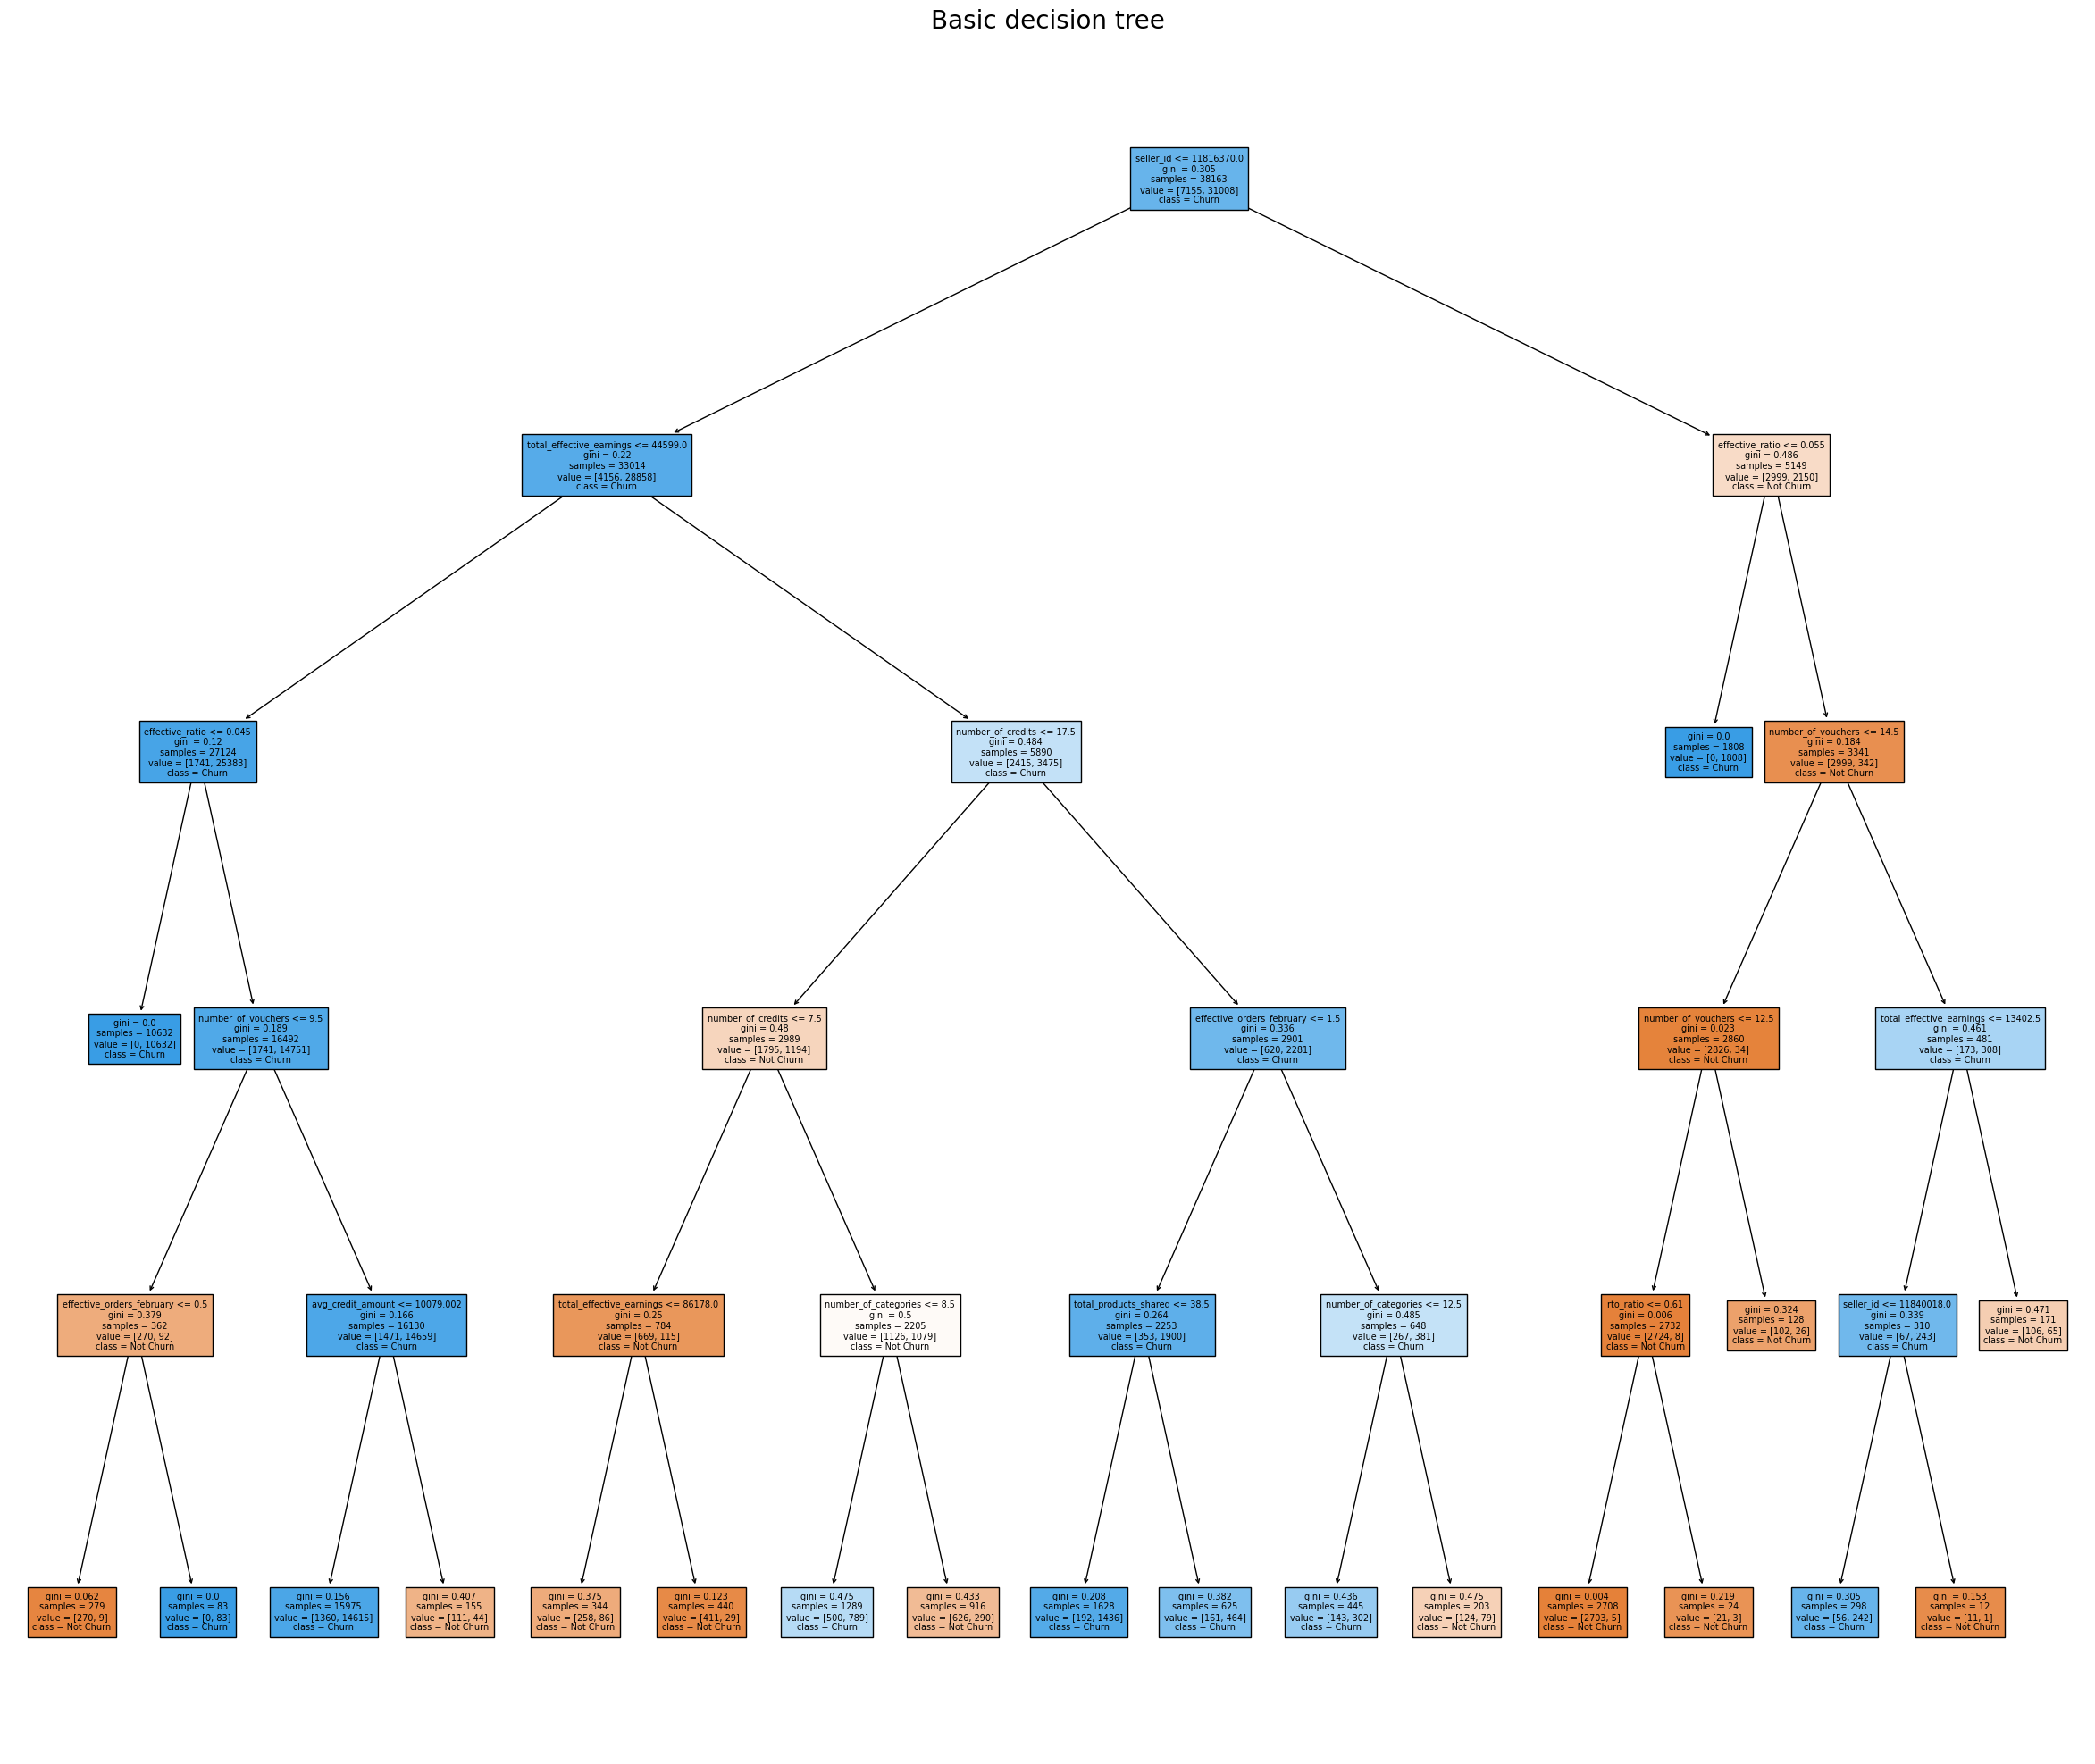

In [30]:
#Creating a decision tree
basic_model = DecisionTreeClassifier(max_depth=5, min_samples_split=200)
basic_model.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(30,25))
plot_tree(basic_model, feature_names=X_train.columns, filled=True, class_names=["Not Churn", "Churn"], impurity=True, fontsize=7)
plt.title("Basic decision tree", fontsize=20)
plt.show()

## Feature Importance

In [31]:
#Model using the same parameters to evaluate feature importance
features_model = XGBClassifier(colsample_bytree=0.9, gamma=0.1, learning_rate=1, max_depth=5, n_estimators=200, reg_alpha=1, reg_lambda=0.05, scale_pos_weight=1)
features_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

**Permutation**

> the next cell is commented, since it takes 14 minutes to run

In [32]:
#This line takes 14 mins to run


# Determine feature importance using the test set & iterating 1,500 times
#permutation_result = permutation_importance(features_model, X_test, y_test, n_repeats=1500, random_state=24)

In [33]:
#Pickling the permutation result
#joblib.dump(permutation_result, '../model/it2_permutation_result.pkl')

In [34]:
#Loading the permutation
permutation_result = joblib.load('../model/it2_permutation_result.pkl')

In [35]:
# Average importance per feature
importances = permutation_result.importances_mean

# Normalize the importances
normalized_importances = importances / importances.sum()


# Creating a DataFrame
permute_importances_df = pd.DataFrame({'Variable': X_train.columns,
                               'Importance': importances,
                               'Normalized Importance': normalized_importances})

permute_importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

#Review
permute_importances_df.head(5)

,Variable,Importance,Normalized Importance
0,effective_ratio,0.196565,0.263952
1,total_effective_earnings,0.185961,0.249712
2,number_of_vouchers,0.124501,0.167183
3,avg_effective_earnings,0.076315,0.102478
4,effective_orders_february,0.032882,0.044154


In [36]:
# Gini  feature importances
gini_importances = features_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(gini_importances)[::-1]

gini_importanceDF = pd.DataFrame({'feature': X_train.columns,
                                'importance (gini reduction)': gini_importances,
})

gini_importanceDF.sort_values(by='importance (gini reduction)', ascending=False, inplace=True, ignore_index=True)

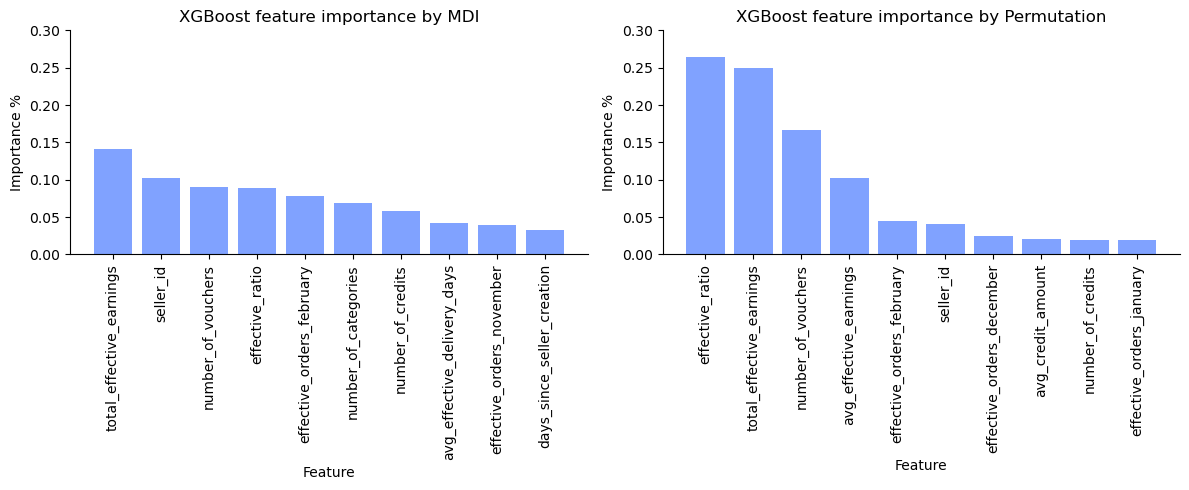

In [37]:
# Feature importance by Gini and permutation
plt.subplots(1, 2, figsize=(12, 5))

# Establishing top X:
top_features_permute = permute_importances_df.iloc[0:10]
gini_importanceDF = gini_importanceDF.iloc[0:10]

# Gini reduction
plt.subplot(1, 2, 1)
plt.bar(gini_importanceDF["feature"], gini_importanceDF["importance (gini reduction)"], color="#80a2ff")
plt.title("XGBoost feature importance by MDI")
plt.xlabel("Feature")
plt.ylim(0, 0.30)
plt.xticks(rotation = 90)
plt.ylabel("Importance %")
sns.despine()

# Permutation
plt.subplot(1, 2, 2)
plt.bar(top_features_permute["Variable"], top_features_permute["Normalized Importance"], color="#80a2ff")
plt.title("XGBoost feature importance by Permutation")
plt.xlabel("Feature")
plt.ylabel("Importance %")
plt.ylim(0, 0.30)
plt.xticks(rotation = 90)
sns.despine()

plt.tight_layout()
plt.show()


Total effective earnings and number of vouchers are present in the top 3 of the normalized feature importance graphs, both in the permutation as MDI (Gini reduction)

In both graphs the most relevant features are cumulative except the effective ratio

## Evaluation of the misclassification

In [38]:
#Prediction:
predicted_labels = xg_model.predict(X_test)

#Comparing with the actual labels: Boolean of the missclassified samples
misclassified_indices = y_test != predicted_labels

#Obtaining the indices:Specific feature values
misclassified_samples = X_test[misclassified_indices]

#Obtaining corresponding the true labels (actuals)
true_labels = y_test[misclassified_indices]

#False positive
is_false_positive = (predicted_labels[misclassified_indices] == 1) & (true_labels == 1)

#False negative
is_false_negative = (predicted_labels[misclassified_indices] == 0) & (true_labels == 0)

In [39]:
misclassified_samples

,seller_id,effective_ratio,rto_ratio,cancelled_ratio,departments_sold,number_of_clients,avg_effective_delivery_days,total_effective_earnings,avg_effective_earnings,avg_client_price,...,avg_vendor_discount,number_of_categories,average_prod_existence_days,total_products_shared,number_of_vouchers,number_of_credits,number_of_used_credits,avg_credit_amount,seller_creation_month,days_since_seller_creation
20617,11616970,0.61,0.17,0.22,2,14,1.919859,119578.0,9.293921,114516.666667,...,8140.0,12,469.0,64,57,7,0,6428.571429,12,131
476,11420810,0.69,0.15,0.15,1,6,1.791759,116502.0,9.468516,99976.923077,...,9883.0,3,375.0,59,41,18,0,7555.555556,10,211
28845,11701836,0.67,0.17,0.17,3,4,2.047693,78195.0,9.880718,356016.666667,...,169394.0,5,430.0,90,28,18,0,6611.111111,1,97
15562,11563473,0.68,0.09,0.18,2,10,1.526056,100491.0,8.809923,43359.090909,...,2157.0,12,382.0,54,44,28,0,7285.714286,12,146
28216,11696357,0.75,0.25,0.00,1,1,1.845300,20872.0,8.847695,49575.000000,...,8390.0,2,627.0,0,61,22,0,6181.818182,1,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34128,11745481,0.25,0.50,0.25,1,2,1.098612,8400.0,9.036106,47900.000000,...,1832.0,2,505.0,0,10,7,0,7142.857143,2,79
13440,11544032,0.60,0.30,0.10,1,2,1.427916,16041.0,7.891518,53695.500000,...,13181.0,8,288.0,1,47,23,1,7086.956522,11,157
33119,11736469,1.00,0.00,0.00,2,4,2.197225,39895.0,8.984694,55600.000000,...,1639.0,4,319.0,5,16,4,0,6750.000000,2,83
39515,11797845,1.00,0.00,0.00,1,1,1.098612,13200.0,8.389587,23800.000000,...,0.0,3,61.0,3,18,7,0,6285.714286,3,55


In [40]:
# DF with the misclassified samples and their type of error
misclassified_data = pd.DataFrame(misclassified_samples, columns=df.columns) 
misclassified_data["is_false_positive"] = (predicted_labels[misclassified_indices] == 1) & (true_labels == 0)
misclassified_data["is_false_negative"] = (predicted_labels[misclassified_indices] == 0) & (true_labels == 1)


#Sanity check:
print(f"""
- Total rows: {misclassified_data["seller_id"].count()}
- False positive: {misclassified_data["is_false_positive"].sum()}
- False negative: {misclassified_data["is_false_negative"].sum()}
- check: {misclassified_data["is_false_negative"].sum() + misclassified_data["is_false_positive"].sum() - misclassified_data["seller_id"].count()}
""")


- Total rows: 582
- False positive: 369
- False negative: 213
- check: 0



In [41]:
#Tagging the misclassified
misclassified_data["is_misclassified"] = 1
#Sanity check
misclassified_data.head(5)

,seller_id,effective_ratio,rto_ratio,cancelled_ratio,departments_sold,number_of_clients,avg_effective_delivery_days,total_effective_earnings,avg_effective_earnings,avg_client_price,...,total_products_shared,number_of_vouchers,number_of_credits,number_of_used_credits,avg_credit_amount,seller_creation_month,days_since_seller_creation,is_false_positive,is_false_negative,is_misclassified
20617,11616970,0.61,0.17,0.22,2,14,1.919859,119578.0,9.293921,114516.666667,...,64,57,7,0,6428.571429,12,131,False,True,1
476,11420810,0.69,0.15,0.15,1,6,1.791759,116502.0,9.468516,99976.923077,...,59,41,18,0,7555.555556,10,211,True,False,1
28845,11701836,0.67,0.17,0.17,3,4,2.047693,78195.0,9.880718,356016.666667,...,90,28,18,0,6611.111111,1,97,False,True,1
15562,11563473,0.68,0.09,0.18,2,10,1.526056,100491.0,8.809923,43359.090909,...,54,44,28,0,7285.714286,12,146,False,True,1
28216,11696357,0.75,0.25,0.00,1,1,1.845300,20872.0,8.847695,49575.000000,...,0,61,22,0,6181.818182,1,99,False,True,1


In [42]:
#Joining the DFs:
#Summary of the misclassified DF
misclassified_summary = misclassified_data[["seller_id", "is_misclassified", "is_false_positive", "is_false_negative"]]

#Joining them together
evaluation_df = pd.merge(X_test, misclassified_summary, how="left", on="seller_id")

#Sanity check:
evaluation_df.head(5)


,seller_id,effective_ratio,rto_ratio,cancelled_ratio,departments_sold,number_of_clients,avg_effective_delivery_days,total_effective_earnings,avg_effective_earnings,avg_client_price,...,total_products_shared,number_of_vouchers,number_of_credits,number_of_used_credits,avg_credit_amount,seller_creation_month,days_since_seller_creation,is_misclassified,is_false_positive,is_false_negative
0,11419049,0.83,0.17,0.00,1,3,1.916923,57043.0,8.649151,42608.333333,...,2,78,26,0,6346.153846,10,211,NaN,NaN,NaN
1,11653024,0.70,0.10,0.10,3,9,1.742219,98281.0,9.549747,102400.000000,...,59,35,15,0,4900.000000,1,114,NaN,NaN,NaN
2,11875266,0.00,0.50,0.50,1,1,1.945910,0.0,0.000000,281050.000000,...,0,2,2,1,5000.000000,4,11,NaN,NaN,NaN
3,11781345,0.50,0.50,0.00,1,1,1.609438,10945.0,8.607674,43550.000000,...,5,19,9,0,6888.888889,2,63,NaN,NaN,NaN
4,11487842,0.37,0.05,0.56,3,15,2.495682,544582.0,10.499751,144875.609756,...,199,81,18,3,8388.888889,10,184,NaN,NaN,NaN


In [43]:
replace_nan_with_zero(evaluation_df, ["is_misclassified"])

,seller_id,effective_ratio,rto_ratio,cancelled_ratio,departments_sold,number_of_clients,avg_effective_delivery_days,total_effective_earnings,avg_effective_earnings,avg_client_price,...,total_products_shared,number_of_vouchers,number_of_credits,number_of_used_credits,avg_credit_amount,seller_creation_month,days_since_seller_creation,is_misclassified,is_false_positive,is_false_negative
0,11419049,0.83,0.17,0.00,1,3,1.916923,57043.0,8.649151,42608.333333,...,2,78,26,0,6346.153846,10,211,0.0,NaN,NaN
1,11653024,0.70,0.10,0.10,3,9,1.742219,98281.0,9.549747,102400.000000,...,59,35,15,0,4900.000000,1,114,0.0,NaN,NaN
2,11875266,0.00,0.50,0.50,1,1,1.945910,0.0,0.000000,281050.000000,...,0,2,2,1,5000.000000,4,11,0.0,NaN,NaN
3,11781345,0.50,0.50,0.00,1,1,1.609438,10945.0,8.607674,43550.000000,...,5,19,9,0,6888.888889,2,63,0.0,NaN,NaN
4,11487842,0.37,0.05,0.56,3,15,2.495682,544582.0,10.499751,144875.609756,...,199,81,18,3,8388.888889,10,184,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536,11447583,1.00,0.00,0.00,1,1,1.098612,23750.0,10.075380,110600.000000,...,1,55,26,0,6846.153846,10,200,0.0,NaN,NaN
9537,11682825,1.00,0.00,0.00,1,2,1.504077,25221.0,9.442364,154050.000000,...,0,12,10,0,5000.000000,1,103,0.0,NaN,NaN
9538,11525485,0.00,1.00,0.00,1,1,1.945910,0.0,0.000000,38200.000000,...,0,16,7,0,7142.857143,11,166,0.0,NaN,NaN
9539,11757808,0.50,0.50,0.00,1,4,2.079442,18375.0,8.720297,33323.333333,...,27,16,6,0,5000.000000,2,73,0.0,NaN,NaN


In [44]:
#Filling the missing values (correct classifications)
evaluation_df["is_false_positive"].fillna(False, inplace=True)
evaluation_df["is_false_negative"].fillna(False, inplace=True)

In [45]:
#Sanity check
nan_vis(evaluation_df)

print(f"misclassification: {((evaluation_df['is_misclassified'].sum() / evaluation_df['is_misclassified'].count()) * 100):.2f} %")


misclassification: 6.10 %


**Understanding the misclassifications using Principal Components**

In [46]:
# Perform Standard Scaling
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

#Creating a DF of the PC scores
PCA_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])

Text(0.5, 1.0, 'Data aggregation in two PCs')

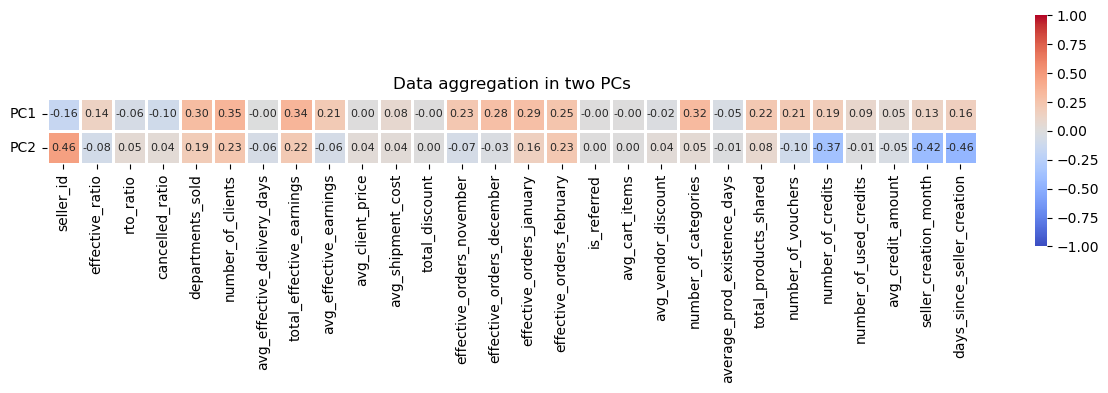

In [47]:
# Visualization of the PC
plt.figure(figsize=(15, 3))

# PC heatmap
ax = sns.heatmap(pca.components_,
                 cmap='coolwarm',
                 yticklabels=["PC" + str(x) for x in range(1, pca.n_components_ + 1)],
                 xticklabels=list(X_test.columns),
                 linewidths=1,
                 annot=True,
                 annot_kws={"size": 8},  # Increase font size for annotations
                 fmt=".2f",  # Display annotations with 2 decimal places
                 vmin=-1,
                 vmax=1,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_aspect("equal")
plt.title("Data aggregation in two PCs")

Non of the variables in the PCA account for a significant relevance (XXXX).

Patterns can be derived from the PCs:
PC1: Focused on cumulative metrics of the seller, number of clients, different categories, and departments (regions where she has sold)

In [48]:
#is_misclassified to int for the visualization
evaluation_df["is_misclassified"] = evaluation_df["is_misclassified"].astype(str)

In [49]:
#Scatterplot of the misclassifications
fig = px.scatter(x=PCA_df["PC1"], y=PCA_df["PC2"], color=evaluation_df["is_misclassified"])

fig.update_layout(
    title="Scatter Plot of PCA Components: misclassification pattern between PC1 -1.05 to 0.08",
    xaxis_title="PC1: cumulative performance",
    yaxis_title="PC2: sellers' duration with Elenas",
)

fig.show()


The model effectively identifies outliers, distinguishing sellers with exceptional or poor metrics. However, it faces challenges in accurately labeling sellers with average metrics. While no clear pattern is observed for misclassifications in PC2, there appears to be a discernible pattern within the range of -1.05X to 0.08X. To gain further insights, I will analyze the misclassifications separately as false positives and false negatives.

In [50]:
#Scatterplot of the false positive
fig = px.scatter(x=PCA_df["PC1"], y=PCA_df["PC2"], color=evaluation_df["is_false_positive"])

fig.update_layout(
    title="Scatter Plot of PCA Components: False positive classifications",
    xaxis_title="PC1: cumulative performance",
    yaxis_title="PC2: sellers' duration with Elenas"
)

fig.show()


The range on the X PC is particularly noticeable among the false positive classifications. To assess the significance of these metrics, I will conduct hypothesis testing for both the specific population within the range and the entire classification as a whole.






In [51]:
#Scatterplot of the false negative
fig = px.scatter(x=PCA_df["PC1"], y=PCA_df["PC2"], color=evaluation_df["is_false_negative"])

fig.update_layout(
    title="Scatter Plot of PCA Components: False negative classifications - no clear pattern",
    xaxis_title="PC1: cumulative performance",
    yaxis_title="PC2: sellers' duration with Elenas"
)

fig.show()


Even though a distinct pattern is not evident for the false negatives, it is notable that the model misclassifies sellers within the same range as the false positives. This alignment in misclassifications is expected and suggests that the model struggles to accurately predict sellers with average metrics in that specific range. Further investigation and analysis will be conducted to gain a deeper understanding of this observation.

In [52]:
fig = px.scatter(x=PCA_df["PC1"], y=PCA_df["PC2"], color=y_test)

fig.update_layout(
    title="Scatter Plot of PCA Components: Churn and not churned sellers",
    xaxis_title="PC1: cumulative performance",
    yaxis_title="PC2: sellers' duration with Elenas"
)

fig.show()

There are two distinct population segments identified using PC1 and PC2, which are partially explained by seller churn or non-churn. However, further analysis to explore the differences between these segments is not deemed relevant for this particular analysis and could be deferred to a future iteration.

**Reviewing the false positive range of PC1**

In [53]:
#Joining the DF's
evaluation_df = pd.concat([evaluation_df, PCA_df], axis=1)

#Establishing the range
PC1_lower_range = -1.05
PC1_upper_range = 0.08

#Sanity check
evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"]== '0.0')]

,seller_id,effective_ratio,rto_ratio,cancelled_ratio,departments_sold,number_of_clients,avg_effective_delivery_days,total_effective_earnings,avg_effective_earnings,avg_client_price,...,number_of_credits,number_of_used_credits,avg_credit_amount,seller_creation_month,days_since_seller_creation,is_misclassified,is_false_positive,is_false_negative,PC1,PC2
3,11781345,0.50,0.50,0.00,1,1,1.609438,10945.0,8.607674,43550.000000,...,9,0,6888.888889,2,63,0.0,False,False,-0.943856,1.198244
8,11848145,0.69,0.15,0.15,1,9,1.631199,162640.0,9.802125,80723.076923,...,4,0,10625.000000,4,28,0.0,False,False,-0.417230,1.909931
13,11545789,0.33,0.00,0.00,1,2,2.197225,0.0,0.000000,91231.333333,...,25,0,6200.000000,11,156,0.0,False,False,-0.013841,-1.776105
16,11803107,0.88,0.00,0.12,1,7,1.098612,111786.0,9.678494,204337.500000,...,11,1,7181.818182,3,53,0.0,False,False,-0.088663,1.325794
17,11436215,0.00,0.50,0.50,1,1,1.945910,0.0,0.000000,95950.000000,...,6,0,6333.333333,10,204,0.0,False,False,-0.688367,-1.499492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532,11417363,0.00,0.50,0.50,1,1,1.945910,0.0,0.000000,150500.000000,...,2,0,6000.000000,9,212,0.0,False,False,-0.874080,-1.419773
9533,11803418,0.50,0.50,0.00,1,3,0.916291,12316.0,8.725670,35850.000000,...,12,0,12083.333333,3,53,0.0,False,False,-0.612110,1.208438
9537,11682825,1.00,0.00,0.00,1,2,1.504077,25221.0,9.442364,154050.000000,...,10,0,5000.000000,1,103,0.0,False,False,-0.200473,0.680267
9538,11525485,0.00,1.00,0.00,1,1,1.945910,0.0,0.000000,38200.000000,...,7,0,7142.857143,11,166,0.0,False,False,-0.941712,-1.081996


## Hypothesis testing:

To further validate the misclassifications, I performed hypothesis testing for false positives, false negatives, and general misclassifications. The selected groups depended on the evaluated metric and the patterns observed in the scatterplots

*Effective Ratio:* Evaluated for misclassified sellers in the PC1 range and the entire population.
    1. The null hypothesis was rejected for both the entire observed seller population and the subgroup with the PC1 pattern, indicating a significant difference in the average ratio of completed orders between misclassified and well-classified sellers.
    2. The average effective orders ratio was significantly higher for misclassified values.
    3. The model classification was expected since the misclassified sellers had a significantly higher effective ratio, which is a positive metric for them.

*Total Effective Earnings:* Due to the influence of total effective earnings on PC1 and the observed pattern for false positives, I conducted this hypothesis test for false positive classifications.
    1. Both the null hypothesis for the specific PC1 range and the entire population could be rejected. The total effective earnings of false positives were significantly higher.

*Number of Credits:* The number of credits was prioritized for hypothesis testing based on the simple tree plot and performed for all misclassified sellers.
    1. The null hypothesis could not be rejected, indicating that the number of credits is, on average, the same for all sellers.

*SellerID:* Prioritized for hypothesis testing based on the simple tree plot and performed for all misclassified sellers.
    1. The null hypothesis could be rejected for the subpopulation within the PC1 range but not for the overall population of analyzed sellers.

*Number of Vouchers:* This feature was selected due to its relevance in the different trees.
    1. The null hypothesis could not be rejected. The difference in the number of vouchers is not significantly higher for sellers within the PC1 range.

*Number of clients:*  This metric was selected due to its relevance for PC2. The test was performed for the false positive cases.
    1. The null hypothesis was rejected both in the subgroup and in the test of the whole population.

In [54]:
#Reviewing the effective earnings of the misclassified range:
#1. Effective ratio:
group1_effective = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '1.0')]["effective_ratio"]
group2_effective = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '0.0')]["effective_ratio"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_effective, group2_effective)

# Results
print("T-statistic:", t_statistic)
print("P-value:", p_value)


T-statistic: 5.5977926718654
P-value: 2.3489699629965403e-08


- I can reject the null hypothesis, meaning that there is a significant difference in the mean of the two groups inside the PC1 range
- The effective ratio average is significantly higher for the misclassified values

In [55]:
#Effective ratio for the whole population
total_effective_misclassified = evaluation_df[(evaluation_df["is_misclassified"] == '1.0')]["effective_ratio"]
total_effective_corrects = evaluation_df[(evaluation_df["is_misclassified"] == '0.0')]["effective_ratio"]

#Two-sample t-test
t_statistic, p_value = stats.ttest_ind(total_effective_misclassified, total_effective_corrects)
# Results
print("T-statistic (effective ratio) for the whole population:", t_statistic)
print("P-value (effective ratio) for the whole population:", p_value)

T-statistic (effective ratio) for the whole population: 12.075486103699381
P-value (effective ratio) for the whole population: 2.4895845813382617e-33


- I can reject the null hypothesis, which means that for the entire population, the average ratio of effective orders for the misclassified sellers is significantly higher vs the correct ones

In [56]:
#2. Total effective earnings for false positives
group1_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_false_positive"] == True)]["total_effective_earnings"]
group2_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_false_positive"] == False)]["total_effective_earnings"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_earnings, group2_earnings)

# Results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 5.247095620327719
P-value: 1.6429534007621123e-07


* The null hypothesis can be rejected, indicating that for this specific range, the misclassified sellers (False positive) had a significant higher mean of total effective earnings

In [57]:
#Effective earnings for the whole population
total_earnings_misclassified = evaluation_df[(evaluation_df["is_false_positive"] == True)]["total_effective_earnings"]
total_earnings_correct = evaluation_df[(evaluation_df["is_false_positive"] == False)]["total_effective_earnings"]

#Two-sample t-test
t_statistic, p_value = stats.ttest_ind(total_earnings_misclassified, total_earnings_correct)
# Results
print("T-statistic (effective earnings) for the whole population:", t_statistic)
print("P-value (effective earnings) for the whole population:", p_value)

T-statistic (effective earnings) for the whole population: 3.3944393717929606
P-value (effective earnings) for the whole population: 0.0006904939096637778


* The null hypothesis can be rejected. The total_effective_earnings was significantly higher for the whole population of false positives

In [58]:
#3. Number of credits:
group1_credits = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '1.0')]["number_of_credits"]
group2_credits = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '0.0')]["number_of_credits"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_credits, group2_credits)

# Results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -0.46546160152511534
P-value: 0.6416317278495214


* I can't reject the null hypothesis. Indicating that there is no significant difference in the number of credits for the misclassified ranges

In [59]:
#4 SellerID
#4. SellerID:
group1_seller_id = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '1.0')]["seller_id"]
group2_seller_id = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '0.0')]["seller_id"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_seller_id, group2_seller_id)

# Results
print("T-statistic: for seller_id", t_statistic)
print("T-statistic: for seller_id:", p_value)


T-statistic: for seller_id 9.692059421374596
T-statistic: for seller_id: 6.3802949712806005e-22


* The null hypothesis can be rejected, indicating that there is a significant mean difference for the correctly classified and misclassified sellers in the PC1 pattern range

In [60]:
#Effective sellerID
total_seller_id_misclassified = evaluation_df[(evaluation_df["is_misclassified"] == '1.0')]["seller_id"]
total_seller_id_correct = evaluation_df[(evaluation_df["is_misclassified"] == '0.0')]["seller_id"]

#Two-sample t-test
t_statistic, p_value = stats.ttest_ind(total_seller_id_misclassified, total_seller_id_correct)
# Results
print("T-statistic (effective earnings) for the whole population:", t_statistic)
print("P-value (effective earnings) for the whole population:", p_value)

T-statistic (effective earnings) for the whole population: -2.075634501850344
P-value (effective earnings) for the whole population: 0.03795449700653713


* The null hypothesis can not be rejected, which means that despite the significant difference on the specific population range of PC1, for the overall sellers the means are not significantly different

In [61]:
#5 number_of_vouchers
group1_number_of_vouchers = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '1.0')]["number_of_vouchers"]
group2_number_of_vouchers = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_misclassified"] == '0.0')]["number_of_vouchers"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_number_of_vouchers, group2_number_of_vouchers)

# Results
print("T-statistic: for seller_id", t_statistic)
print("T-statistic: for seller_id:", p_value)


T-statistic: for seller_id 1.4924384570311275
T-statistic: for seller_id: 0.13568009211948792


The null hypothesis can't be rejected. The difference for the number of vouchers is not significantly higher for the sellers inside the PC1 range

In [62]:
#6. Number of clients for false positives
group1_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_false_positive"] == True)]["number_of_clients"]
group2_earnings = evaluation_df[(evaluation_df["PC1"] >= PC1_lower_range) & (evaluation_df["PC1"] <=PC1_upper_range) & (evaluation_df["is_false_positive"] == False)]["number_of_clients"]

# Two-sample t-test
t_statistic, p_value = stats.ttest_ind(group1_earnings, group2_earnings)

# Results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 4.964827031817049
P-value: 7.225899250718882e-07


* The null hypothesis can be rejected, the difference between the number of clients is significant for the false positive cases, this is something that the model should have addressed

In [63]:
#Effective earnings for the whole population
total_earnings_misclassified = evaluation_df[(evaluation_df["is_false_positive"] == True)]["number_of_clients"]
total_earnings_correct = evaluation_df[(evaluation_df["is_false_positive"] == False)]["number_of_clients"]

#Two-sample t-test
t_statistic, p_value = stats.ttest_ind(total_earnings_misclassified, total_earnings_correct)
# Results
print("T-statistic (effective earnings) for the whole population:", t_statistic)
print("P-value (effective earnings) for the whole population:", p_value)

T-statistic (effective earnings) for the whole population: 2.6106382894914346
P-value (effective earnings) for the whole population: 0.009051476533328839


* The null hypothesis can be rejected, the difference between the number of clients is significant for the false positive cases for the entire population

## SHAP Analysis

In [66]:

# Fit tree-specific kernel for SHAP  
explainer = shap.TreeExplainer(features_model)

# Obtain SHAP values 
shap_values = explainer.shap_values(X_train)


/Users/mauriciomoreno/opt/anaconda3/envs/capstone_shap/lib/python3.8/site-packages/shap/plots/_beeswarm.py:664: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



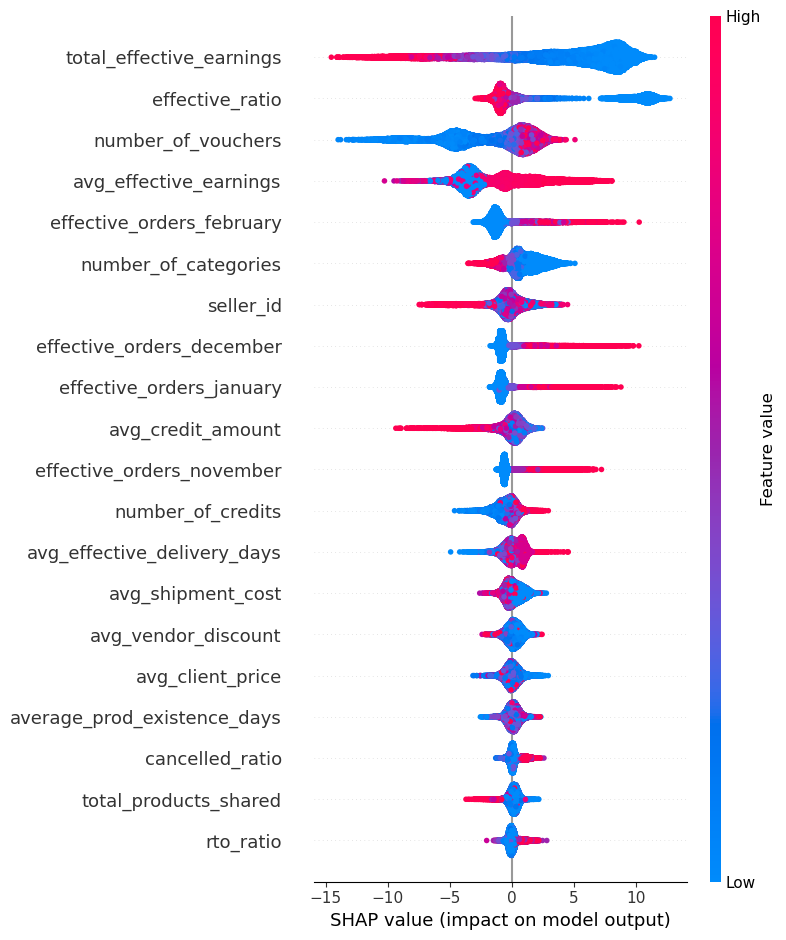

In [65]:

# Global interpretation - summary plot - type = 'dot'
shap.initjs()

shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)


- The total effective earnings exhibit the expected behavior, where sellers with higher cumulative earnings tend to have a higher retention rate, resulting in a classification of 0 (non-churn).
- Other metrics, such as the effective ratio and the number of vouchers, provide interesting insights into seller retention.
    - The effective ratio plays a significant role in influencing churn, indicating that sellers with a high effective ratio expect their orders to be fulfilled without any issues or complications. However, a good effective ratio does not guarantee retention, suggesting that if these expectations are not met, sellers may choose to leave.
    - The number of vouchers given to a seller has proven to be highly indicative of churn. It is hypothesized that these vouchers may be provided in response to returns or cancellations, indicating negative experiences for the sellers. Further analysis is necessary to validate and explore this hypothesis more extensively.